# Extracting Human Faces From Images

## Imports

In [223]:
import cv2 
import getch
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import random

from huggingface_hub import hf_hub_download
from IPython.display import clear_output
from PIL import Image
from supervision import Detections
from ultralytics.engine.results import Results
from ultralytics import YOLO

## Constants

In [224]:
# Dataset paths
dataset_path = "dataset"
train_csv_path = "dataset/train.csv"
test_csv_path = "dataset/test.csv"

## Data Preprocessing

In [225]:
# loading annotation files
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

In [226]:
train_csv.head()

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


## Use Model

In [227]:
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
model = YOLO(model_path)

## Test

In [228]:
image_paths = train_csv["file_name"].tolist()
image_labels = train_csv["label"].tolist()

In [229]:
len(image_paths)

79950

In [230]:
len(image_labels)

79950

Image loaded successfully: dataset/train_data/3bb2e94a10c544c097333aaa98b5a13b.jpg

0: 448x640 1 FACE, 4.4ms
Speed: 1.3ms preprocess, 4.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)
Original image:  78407
Found 1 face(s). Cropping and saving...


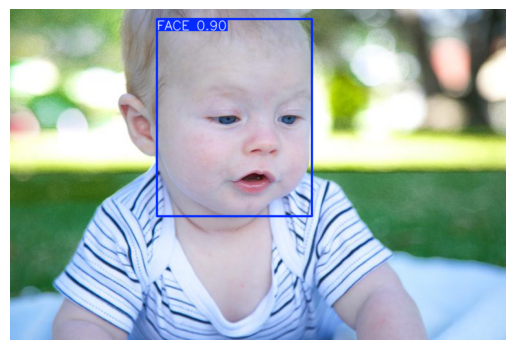

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
isContinue = 0

isContinue = int(input("Continue (0 exit | 1 continue): "))

# for j in range(len(image_paths)):
while (isContinue):
    clear_output(wait=True)

    # temporary variable for testing !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    j = random.randint(0, 79949)
    original_image_bgr = cv2.imread(os.path.join(dataset_path, image_paths[j]))
        
    if original_image_bgr is None:
        print(f"Error: Could not load image from path: {os.path.join(dataset_path, image_paths[j])}")
        exit() 
    else:
        print(f"Image loaded successfully: {os.path.join(dataset_path, image_paths[j])}")

        output: list[Results] = model(original_image_bgr) # Pass the BGR image array
        results_ultralytics: Results = output[0] # Get results for the first (only) image

        # Access the bounding boxes (xyxy format) from the results
        # .cpu() moves tensor to CPU, .numpy() converts to NumPy array
        bboxes_xyxy = results_ultralytics.boxes.xyxy.cpu().numpy()

        # Define the directory to save cropped faces
        if image_labels[j] == 0:
            output_crop_dir = "cropped_faces_dataset/human"
        if image_labels[j] == 1:
            output_crop_dir = "cropped_faces_dataset/AI"

        os.makedirs(output_crop_dir, exist_ok=True) # Create directory if it doesn't exist

        # Define a base name for the output files
        base_filename = os.path.splitext(os.path.basename(os.path.join(dataset_path, image_paths[j])))[0]

        print("Original image: ", j)
        print(f"Found {len(bboxes_xyxy)} face(s). Cropping and saving...")

        if len(bboxes_xyxy) > 0:
            for i, bbox in enumerate(bboxes_xyxy):
                # Extract integer coordinates (xmin, ymin, xmax, ymax)
                x_min, y_min, x_max, y_max = map(int, bbox[:4])

                # Add padding or ensure coordinates are within bounds if necessary (optional)
                padding = 0
                h, w = original_image_bgr.shape[:2]
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(w, x_max + padding)
                y_max = min(h, y_max + padding)

                # Crop the face region from the original BGR image using NumPy slicing
                cropped_face_bgr = original_image_bgr[y_min:y_max, x_min:x_max]

                # Check if the crop is valid (has width and height)
                if cropped_face_bgr.shape[0] > 256 and cropped_face_bgr.shape[1] > 256:
                    cropped_face_rgb = cv2.cvtColor(cropped_face_bgr, cv2.COLOR_BGR2RGB)
                    cropped_face_pil = Image.fromarray(cropped_face_rgb)
                    output_crop_path = os.path.join(output_crop_dir, f"{base_filename}_face{i}.jpg")

                    # Save the cropped face image
                    cropped_face_pil.save(output_crop_path)
                    print(f"Saved cropped face {i} to: {output_crop_path}")
                else:
                    print(f"Warning: Skipped saving face {i} due to invalid dimensions after cropping.")
            # ----------------------------------------------------------------------------
            annotated_image_bgr: np.ndarray = results_ultralytics.plot()
            annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
            
            plt.imshow(annotated_image_rgb)
            plt.axis("off")
            plt.show(block=False)

            isContinue = int(input("Continue (0 exit | 1 continue): "))

            plt.close()
            # ----------------------------------------------------------------------------
        else:
            print("No faces were detected in the image.")

        